# Algorithmics Trading Using LSTM Long Strategy

## Import Data

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
from datetime import date

import yfinance as yf
import pyfolio as pf

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)

In [91]:
data = yf.download('MSFT')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064383,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061655,47894400
...,...,...,...,...,...,...
2022-06-06,272.059998,274.179993,267.220001,268.750000,268.750000,22400300
2022-06-07,266.640015,273.130005,265.940002,272.500000,272.500000,22860700
2022-06-08,271.709991,273.000000,269.609985,270.410004,270.410004,17372300


<AxesSubplot:xlabel='Date'>

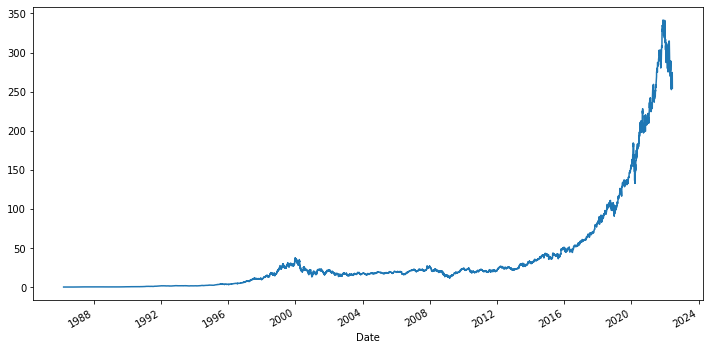

In [92]:
data['Adj Close'].plot()

## Compute Returns and Define Target

In [93]:
data['returns'] = data['Adj Close'].pct_change()
data['target'] = np.where(data['returns'].shift(-1) > 0, 1, 0)

## Scale the Data by Rolling Min-Max Method

In [94]:
data2 = data.copy()

p=21*2
data2['min'] = data2['Low'].rolling(p).min()
data2['max'] = data2['High'].rolling(p).max()
data2.dropna(inplace=True)

data2['Open'] = (data2['Open']-data2['min'])/(data2['max']-data2['min'])
data2['High'] = (data2['High']-data2['min'])/(data2['max']-data2['min'])
data2['Low'] = (data2['Low']-data2['min'])/(data2['max']-data2['min'])
data2['Close'] = (data2['Close']-data2['min'])/(data2['max']-data2['min'])
data2['Adj Close'] = (data2['Adj Close']-data2['min'])/(data2['max']-data2['min'])
data2.dropna(inplace=True)
data2

,Open,High,Low,Close,Adj Close,Volume,returns,target,min,max
Date,,,,,,,,,,
1986-05-12,0.649342,0.753232,0.649342,0.675314,-0.559624,10483200,0.007874,1,0.088542,0.121962
1986-05-13,0.666656,0.719986,0.666656,0.693321,-0.584450,3830400,0.007812,0,0.089410,0.121962
1986-05-14,0.693321,0.693321,0.666656,0.666656,-0.601211,9302400,-0.007752,0,0.089410,0.121962
1986-05-15,0.666656,0.719986,0.666656,0.666656,-0.601211,3801600,0.000000,1,0.089410,0.121962
1986-05-16,0.666656,0.773316,0.666656,0.693321,-0.584450,11952000,0.007812,0,0.089410,0.121962
...,...,...,...,...,...,...,...,...,...,...
2022-06-06,0.423051,0.458058,0.343131,0.368395,0.368395,22400300,-0.004703,1,246.440002,307.000000
2022-06-07,0.353085,0.466527,0.340850,0.455515,0.455515,22860700,0.013953,0,246.440002,303.649994
2022-06-08,0.462143,0.485735,0.423738,0.438369,0.438369,17372300,-0.007670,0,246.440002,301.119995


Adj Close is showing NEGATIVE values

In [95]:
data2['target'].value_counts()

1    4598
0    4498
Name: target, dtype: int64

## Create X-y Pair for LSTM

In [96]:
def sliding_window(data, timesteps):
    x = []
    y = []

    for i in range(len(data)-timesteps):
        _x = data.iloc[i:(i+timesteps)][['Open','High','Low','Adj Close']]
        _y = data.iloc[i+timesteps-1]['target']
    
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [97]:
timesteps = 20
X,y = sliding_window(data2, timesteps)

In [98]:
X.shape,y.shape

((9076, 20, 4), (9076,))

## Train-Test Data Split

In [56]:
# Total dataset length
dataset_length = X.shape[0]

# Training dataset length
split = int(dataset_length * 0.7)
split

6353

In [57]:
# Splitiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6353, 20, 4) (2723, 20, 4)
(6353,) (2723,)


## Define the Model

In [58]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM,Dense

# feature = X_train.shape[2]
# hidden_size = 5

# model = Sequential()
# model.add(LSTM(hidden_size,input_shape=(timesteps,feature)))
# model.add(Dense(1, activation='sigmoid'))

In [76]:
#Stacked LSTM Moddel

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense

feature = X_train.shape[2]
hidden_size = 5

model = Sequential()
model.add(LSTM(hidden_size,return_sequences=True,input_shape=(timesteps,feature)))
model.add(LSTM(hidden_size,return_sequences=True))
model.add(LSTM(hidden_size))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Bidirectional LSTM model 

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM,Dense,Bidirectional

# feature = X_train.shape[2]
# hidden_size = 5

# model = Sequential()
# model.add(Bidirectional(LSTM(hidden_size,input_shape=(timesteps,feature))))
# model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Bidirectional Stacked LSTM model 

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM,Dense,Bidirectional

# feature = X_train.shape[2]
# hidden_size = 5

# model = Sequential()
# model.add(Bidirectional(LSTM(hidden_size,return_sequences=True,input_shape=(timesteps,feature))))
# model.add(Bidirectional(LSTM(hidden_size)))
# model.add(Dense(1, activation='sigmoid'))

In [77]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

## Train the Model

In [78]:
history = model.fit(X_train, y_train, epochs=300,batch_size=32)

Epoch 1/300
199/199 [==============================] - 6s 15ms/step - loss: 0.6973 - accuracy: 0.5028
Epoch 2/300
199/199 [==============================] - 3s 14ms/step - loss: 0.6968 - accuracy: 0.5028
Epoch 3/300
199/199 [==============================] - 3s 14ms/step - loss: 0.6964 - accuracy: 0.5028
Epoch 4/300
199/199 [==============================] - 3s 14ms/step - loss: 0.6960 - accuracy: 0.5028
Epoch 5/300
199/199 [==============================] - 3s 14ms/step - loss: 0.6956 - accuracy: 0.5028
Epoch 6/300
199/199 [==============================] - 3s 14ms/step - loss: 0.6953 - accuracy: 0.5028
Epoch 7/300
199/199 [==============================] - 3s 15ms/step - loss: 0.6950 - accuracy: 0.5028
Epoch 8/300
199/199 [==============================] - 3s 15ms/step - loss: 0.6948 - accuracy: 0.5028
Epoch 9/300
199/199 [==============================] - 3s 15ms/step - loss: 0.6946 - accuracy: 0.5028
Epoch 10/300
199/199 [==============================] - 3s 15ms/step - loss: 0.694

## Evaluate the Model

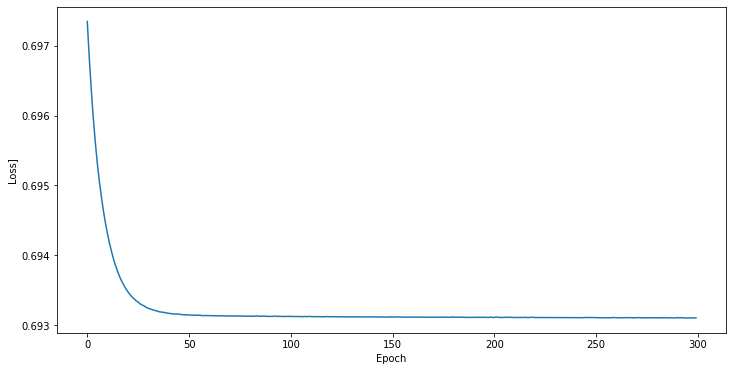

In [79]:
loss = history.history['loss']
epoch = range(len(loss))

import matplotlib.pyplot as plt

plt.plot(epoch,loss)
plt.xlabel('Epoch')
plt.ylabel('Loss]')
plt.show()

In [80]:
loss, acc = model.evaluate(X_test,y_test)
print(f"Accuracy of the model = {np.round(acc*100,2)}%")

86/86 [==============================] - 1s 3ms/step - loss: 0.6922 - accuracy: 0.5244
Accuracy of the model = 52.44%


In [81]:
y_pred = np.where(model.predict(X_test)>0.5,1,0)

In [ ]:
#[print(x) for x in y_pred]

In [82]:
sum(y_test==0), sum(y_pred==0)

(1292, array([487]))

In [83]:
sum(y_test==1), sum(y_pred==1)

(1431, array([2236]))

<AxesSubplot:>

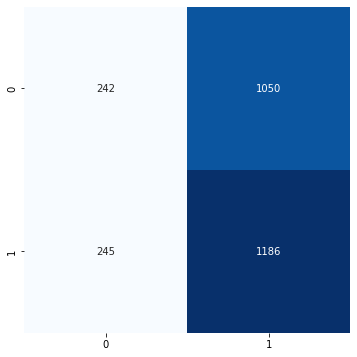

In [84]:
from sklearn.metrics import confusion_matrix
matrix_confusion = confusion_matrix(y_test, y_pred)
import seaborn as sns 
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [87]:
# Run the code to view the classification report metrics
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.50      0.19      0.27      1292
         1.0       0.53      0.83      0.65      1431

    accuracy                           0.52      2723
   macro avg       0.51      0.51      0.46      2723
weighted avg       0.51      0.52      0.47      2723



In [99]:
data.shape, X.shape

((9137, 8), (9076, 20, 4))

## Trade Analytics

In [100]:
offset = len(data)-len(X)
data.drop(data.index[:offset], axis=0, inplace=True)
data['signal'] = np.where(model.predict(X)>0.5,1,0)
data

,Open,High,Low,Close,Adj Close,Volume,returns,target,signal
Date,,,,,,,,,
1986-06-10,0.113715,0.113715,0.111979,0.113715,0.071476,3427200,0.000000,0,1
1986-06-11,0.113715,0.113715,0.111979,0.113715,0.071476,2304000,0.000000,0,1
1986-06-12,0.113715,0.113715,0.108507,0.109375,0.068748,13708800,-0.038165,0,1
1986-06-13,0.109375,0.110243,0.108507,0.109375,0.068748,7891200,0.000000,0,1
1986-06-16,0.109375,0.110243,0.107639,0.108507,0.068203,9590400,-0.007936,1,1
...,...,...,...,...,...,...,...,...,...
2022-06-06,272.059998,274.179993,267.220001,268.750000,268.750000,22400300,-0.004703,1,1
2022-06-07,266.640015,273.130005,265.940002,272.500000,272.500000,22860700,0.013953,0,1
2022-06-08,271.709991,273.000000,269.609985,270.410004,270.410004,17372300,-0.007670,0,1


In [101]:
data['strategy_returns'] = data['returns'].shift(-1) * data['signal']

# Drop the missing values
data.dropna(inplace=True)
data

,Open,High,Low,Close,Adj Close,Volume,returns,target,signal,strategy_returns
Date,,,,,,,,,,
1986-06-10,0.113715,0.113715,0.111979,0.113715,0.071476,3427200,0.000000,0,1,0.000000
1986-06-11,0.113715,0.113715,0.111979,0.113715,0.071476,2304000,0.000000,0,1,-0.038165
1986-06-12,0.113715,0.113715,0.108507,0.109375,0.068748,13708800,-0.038165,0,1,0.000000
1986-06-13,0.109375,0.110243,0.108507,0.109375,0.068748,7891200,0.000000,0,1,-0.007936
1986-06-16,0.109375,0.110243,0.107639,0.108507,0.068203,9590400,-0.007936,1,1,0.015999
...,...,...,...,...,...,...,...,...,...,...
2022-06-03,270.309998,273.450012,268.410004,270.019989,270.019989,28048000,-0.016607,0,1,-0.004703
2022-06-06,272.059998,274.179993,267.220001,268.750000,268.750000,22400300,-0.004703,1,1,0.013953
2022-06-07,266.640015,273.130005,265.940002,272.500000,272.500000,22860700,0.013953,0,1,-0.007670


In [102]:
data['trade'] = data['signal'] - data['signal'].shift(1)
data

,Open,High,Low,Close,Adj Close,Volume,returns,target,signal,strategy_returns,trade
Date,,,,,,,,,,,
1986-06-10,0.113715,0.113715,0.111979,0.113715,0.071476,3427200,0.000000,0,1,0.000000,NaN
1986-06-11,0.113715,0.113715,0.111979,0.113715,0.071476,2304000,0.000000,0,1,-0.038165,0.0
1986-06-12,0.113715,0.113715,0.108507,0.109375,0.068748,13708800,-0.038165,0,1,0.000000,0.0
1986-06-13,0.109375,0.110243,0.108507,0.109375,0.068748,7891200,0.000000,0,1,-0.007936,0.0
1986-06-16,0.109375,0.110243,0.107639,0.108507,0.068203,9590400,-0.007936,1,1,0.015999,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03,270.309998,273.450012,268.410004,270.019989,270.019989,28048000,-0.016607,0,1,-0.004703,0.0
2022-06-06,272.059998,274.179993,267.220001,268.750000,268.750000,22400300,-0.004703,1,1,0.013953,0.0
2022-06-07,266.640015,273.130005,265.940002,272.500000,272.500000,22860700,0.013953,0,1,-0.007670,0.0


In [103]:
data['trade'].value_counts()

 0.0    8968
-1.0      53
 1.0      53
Name: trade, dtype: int64

## Equity Curve

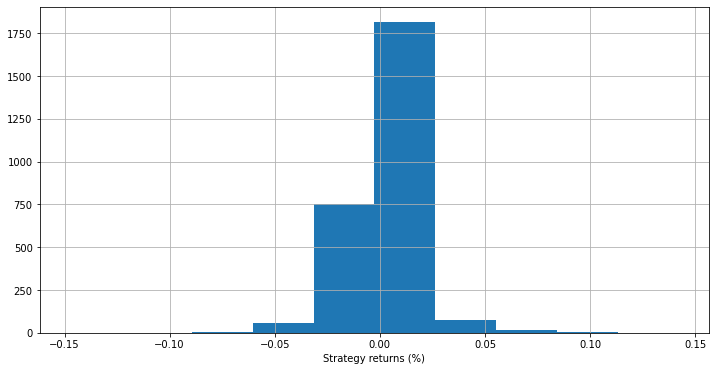

In [104]:
import matplotlib.pyplot as plt
data.strategy_returns[split:].hist()
plt.xlabel('Strategy returns (%)')
plt.show()

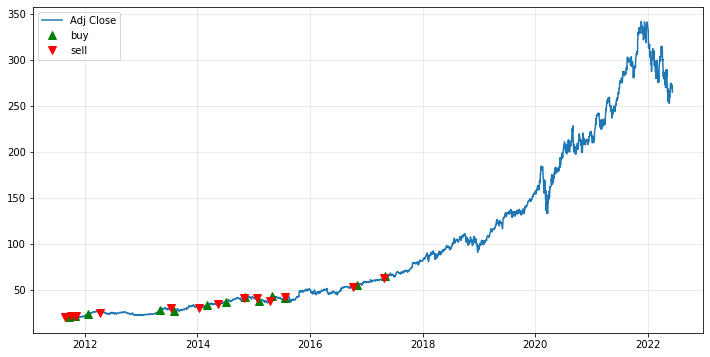

In [105]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(data.iloc[split:]['Adj Close'], label = 'Adj Close')
plt.plot(data[split:].loc[data.trade == 1].index, data[split:]['Adj Close'][data.trade == 1], '^', color = 'g', markersize = 8,label='buy')
plt.plot(data[split:].loc[data.trade == -1].index, data[split:]['Adj Close'][data.trade == -1], 'v',color = 'r', markersize = 8,label='sell')
plt.legend()

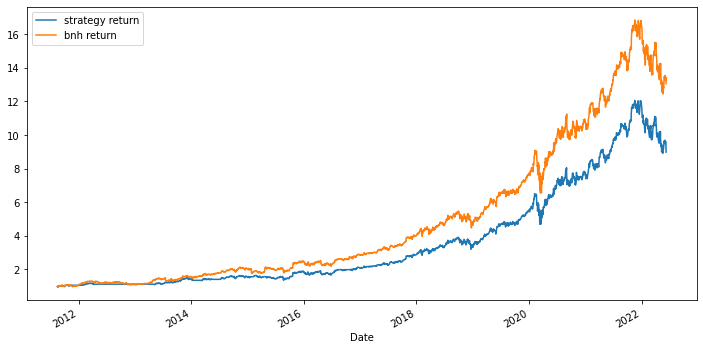

In [106]:
(data.strategy_returns[split:]+1).cumprod().plot(label='strategy return')
(data.returns[split:]+1).cumprod().plot(label='bnh return')
plt.legend()

Start date,1986-06-10
End date,2022-06-09
Total months,432
,Backtest
Annual return,10.6%
Cumulative returns,3674.9%
Annual volatility,23.4%
Sharpe ratio,0.55
Calmar ratio,0.19
Stability,0.64
Max drawdown,-57.2%


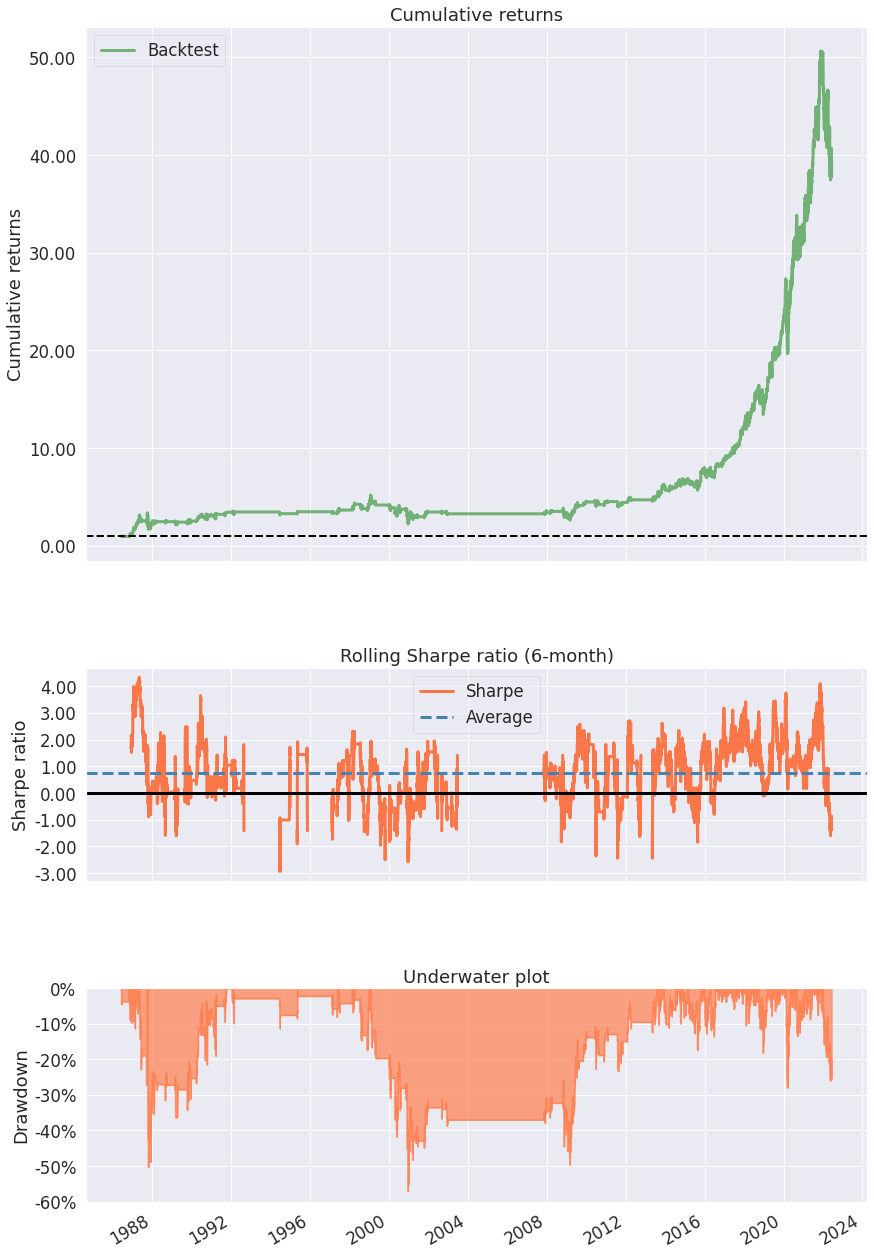

In [108]:
pf.create_simple_tear_sheet(data.strategy_returns)

In [109]:
model.save('lstm.h5')

In [113]:
model2 = tf.keras.models.load_model('lstm.h5')